<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/ANN_Iris_Regulization_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an experiment to learn how to create mini-batches and how they impact the model results . I create a custom ANN by building my own class instead of using sequentail. I also regularize the data by dividing the training sets into batches using DataLoader, TensorDataset and sklearn train_test_split.


## GoogleColab made thanks to a course by Mike X Cohen, sincxpress.com

In [113]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [114]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

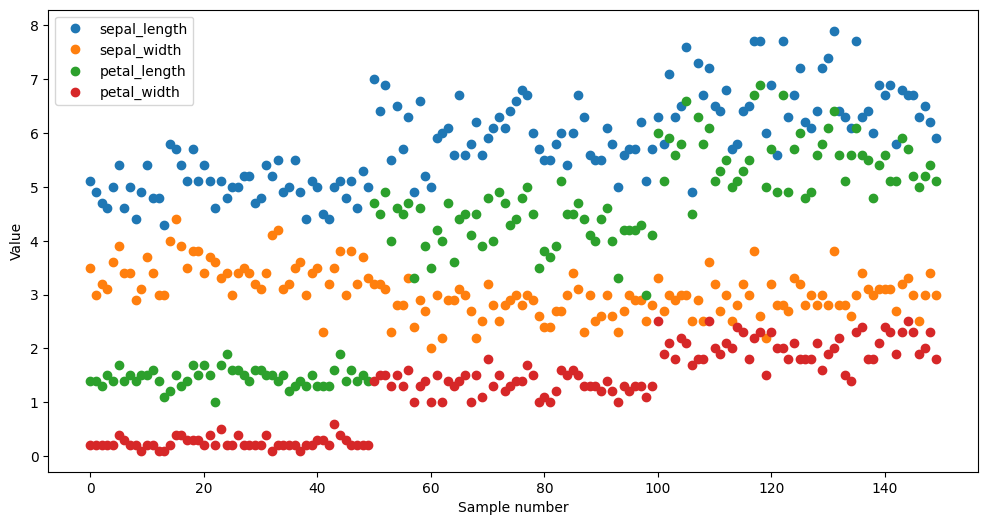

In [115]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [116]:
# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)

# labels[iris.species=='setosa']   = 0
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [117]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data, test_labels)

def create_data(power):
    batchsize = 2 ** power

    # finally, translate into dataloader objects
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
    test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    return train_loader, test_loader

# Construct the model and training plans

In [118]:
class ANNclass(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(4, 64)

        self.hidden = nn.Linear(64, 64)

        self.output = nn.Linear(64, 3)

    def forward(self, x):

        x = self.input(x)
        x = F.relu(x)

        x = self.hidden(x)
        x = F.relu(x)

        x = self.output(x)

        return x

In [119]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = ANNclass()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.001)

  return ANNiris, lossfun, optimizer

In [120]:
# train the model

# global parameter
numepochs = 2500

def trainTheModel(train_loader, test_loader):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses


# Test it out

In [121]:
all_train_acc = []
all_test_acc = []
all_losses = []

for i in range(1,7):
    train_loader, test_loader = create_data(i)

    # create a model
    ANNiris,lossfun,optimizer = createANewModel()

    # train the model
    trainAcc, testAcc, losses = trainTheModel(train_loader, test_loader)
    all_train_acc.append(trainAcc)
    all_test_acc.append(testAcc)
    all_losses.append(losses)

In [122]:
all_train_acc = np.array(all_train_acc)
all_test_acc = np.array(all_test_acc)
all_losses = np.array(all_losses)

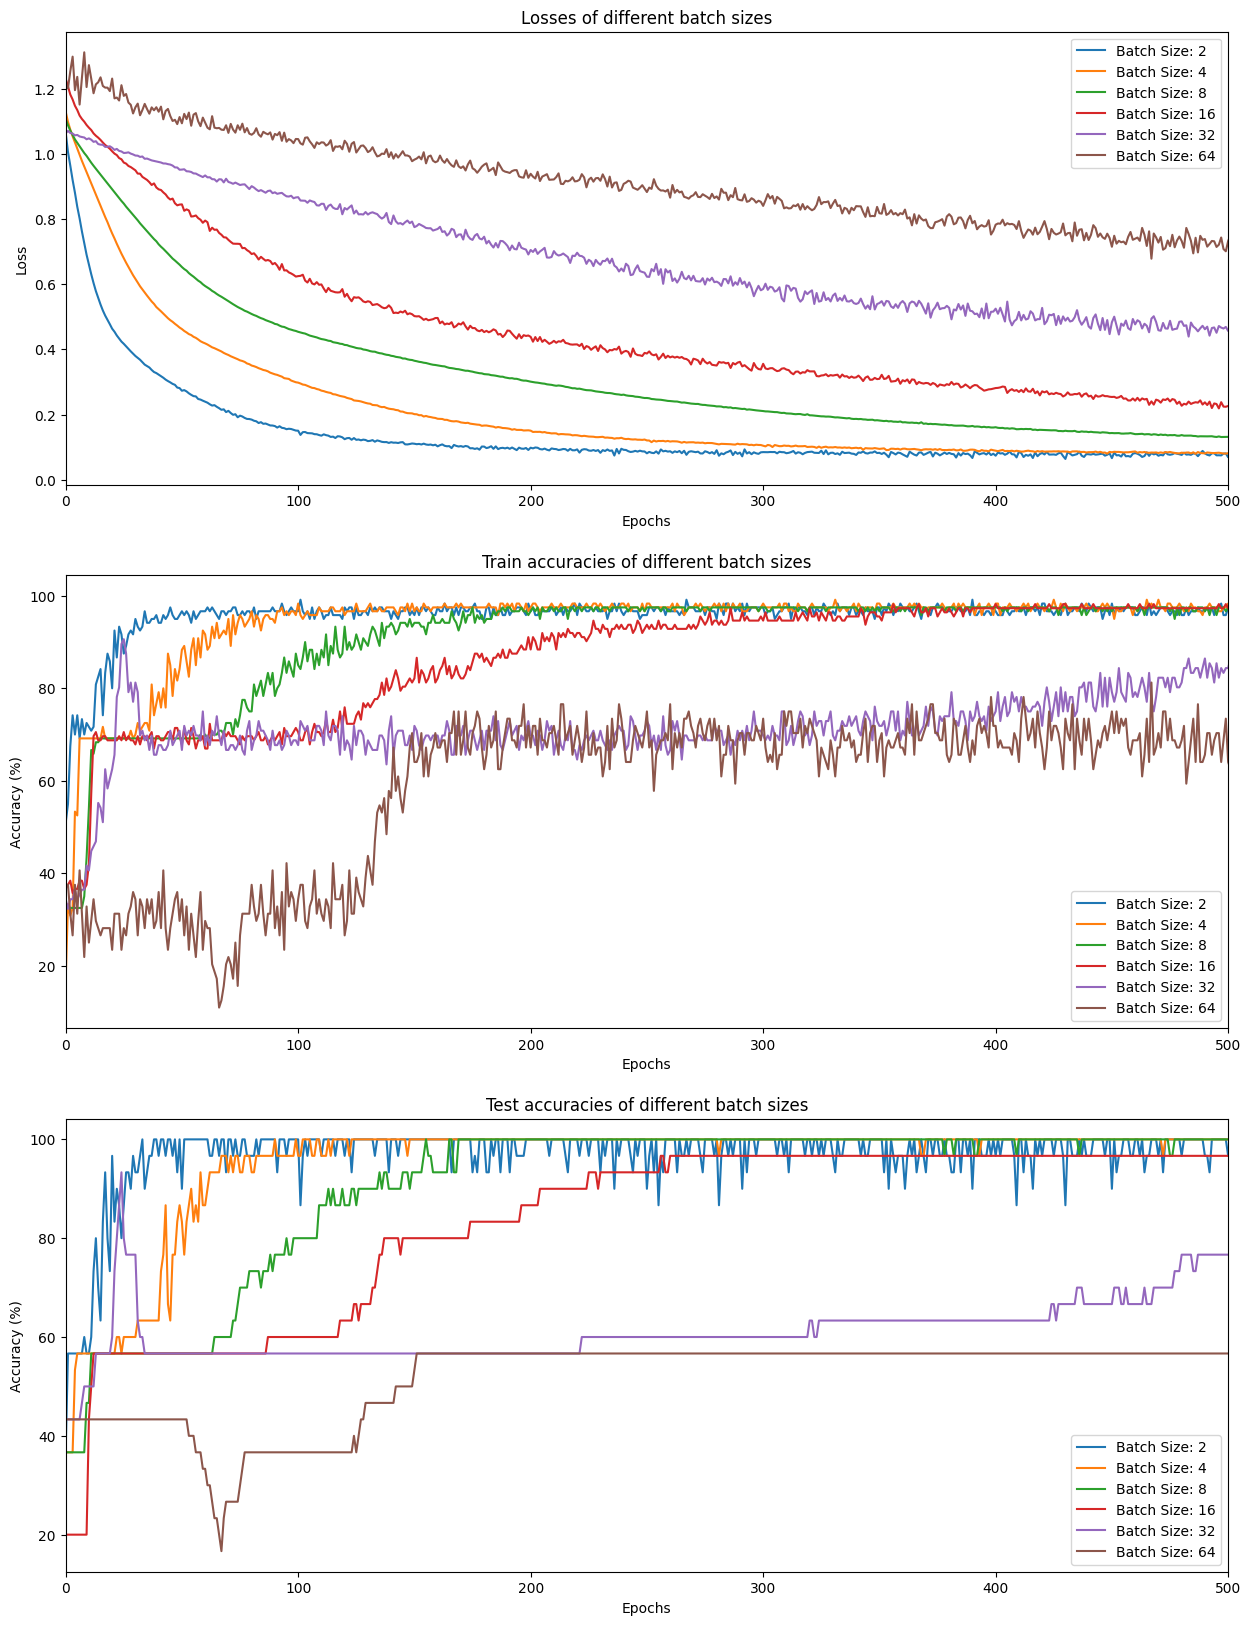

In [123]:
# Define the batch sizes
powers = np.arange(6) + 1
batch_sizes = [2 ** power for power in powers]

# Plot the results for all batch sizes
fig, ax = plt.subplots(3, 1, figsize=(15, 20))

for i in range(len(batch_sizes)):
    trainAcc = all_train_acc[i]
    testAcc = all_test_acc[i]
    losses = all_losses[i]

    # Plot losses
    ax[0].plot(losses, label=f'Batch Size: {batch_sizes[i]}')

    # Plot train accuracies
    ax[1].plot(trainAcc, label=f'Batch Size: {batch_sizes[i]}')

    # Plot test accuracies
    ax[2].plot(testAcc, label=f'Batch Size: {batch_sizes[i]}')

# Set labels and titles
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses of different batch sizes')
ax[0].legend()
ax[0].set_xlim([0,500])

ax[1].set_title('Train accuracies of different batch sizes')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()
ax[1].set_xlim([0,500])

ax[2].set_title('Test accuracies of different batch sizes')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy (%)')
ax[2].legend()
ax[2].set_xlim([0,500])

plt.show()